# ** Building BERT **
![Bert_iamthe_Machine](static/images/Bert_iamthe_Machine.png)

In [1]:
# Bring in all dependencies
import pandas as pd
import requests
import numpy as np
import scipy as sp
import json
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from statistics import mode

ModuleNotFoundError: No module named 'kneed'

In [ ]:
########## Read in data file ##########
path = 'static/resources/model_data.csv'
model_data = pd.read_csv(path,index_col = False)
model_data.set_index('Symbol', inplace=True)
model_data

,Price Change,Dividend Change,Volume Change,Price Volitility,Dividend Volitility,Volume Volitility,Stock Volitility Score,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Undefined,Sector_Utilities
Symbol,,,,,,,,,,,,,,,,,,,
ACA,-0.041705,0.0,-20000.0,1,1,1,3,0,0,0,0,0,0,0,1,0,0,0,0
ADCT,0.088237,0.0,-20000.0,1,1,1,3,0,0,0,0,0,0,1,0,0,0,0,0
AFB,0.000708,0.0,-20000.0,2,1,1,4,0,0,0,0,0,1,0,0,0,0,0,0
AGCO,0.000571,0.0,-20000.0,1,1,1,3,0,0,0,0,0,0,0,1,0,0,0,0
AIRC,-0.048588,0.0,-20000.0,1,1,1,3,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNT,0.036614,0.0,-20000.0,4,1,1,6,0,0,0,0,0,0,0,0,0,1,0,0
WIA,0.000068,0.0,-20000.0,2,1,1,4,0,0,0,0,0,1,0,0,0,0,0,0
WRI,0.008776,0.0,-20000.0,1,1,1,3,0,0,0,0,0,0,0,0,1,0,0,0


# Define Model Structure

In [ ]:
# define the initial number of clusters
n_clusters = 5

######### Build a pipeline to process the data #########
preprocessor = Pipeline([
    # use MinMaxScaler becuase we do not know if features follow a normal distribution
    ("scaler", StandardScaler()),
    
    # PCA class to perform dimensionality reduction
    ("pca", PCA(n_components=2, random_state=42)),
])


######### Build a pipeline to pipeline to perform clustering #########
clusterer = Pipeline([(
    "kmeans",
    KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        n_init=50,
        max_iter=500,
        random_state=42
    )
)])


######### Chain the 2 pipelines to form the full pipeline #########
test_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clusterer", clusterer)
])

test_pipe.fit(model_data)

######## Evaluate the performance by calculating the silhouette coefficient #########
preprocessed_data = test_pipe["preprocessor"].transform(model_data)

predicted_labels = test_pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

######## Create a df with of model data #########

pca_df = pd.DataFrame(
    test_pipe["preprocessor"].transform(model_data),
    columns=["component_1", "component_2"],
)

######## Add a column with cluster assignments #########

pca_df["predicted_cluster"] = test_pipe["clusterer"]["kmeans"].labels_

######## Create a plot of clusters #########

plt.style.use("fivethirtyeight")

plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    pca_df["component_1"],
    pca_df["component_2"],
    s=50,
    data=pca_df,
    hue= pca_df["predicted_cluster"],
#     style="true_label",
    palette="Set1",
)

scat.set_title("Clustering results from Model Data")

plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc=2,
    borderaxespad=0.0
)

plt.show()

# Parameter Tuning

In [11]:
######### Create a dictionary to hold parameter vlaues for comparison later #########
parameter_dict = {
    'Parameter_Changed': [],
    'PCA_n_components': [],
    'n_clusters': [],
    'n_init': [],
    'max_iter': [],
    'silhouette_coef': []   
}

# Capture initial values of model
parameter_dict['Parameter_Changed'].append('initial_vals')
parameter_dict['PCA_n_components'].append(test_pipe["preprocessor"]["pca"].n_components)
parameter_dict['n_clusters'].append(test_pipe["clusterer"]["kmeans"].n_clusters)
parameter_dict['n_init'].append(test_pipe["clusterer"]["kmeans"].n_init)
parameter_dict['max_iter'].append(test_pipe["clusterer"]["kmeans"].max_iter)
parameter_dict['silhouette_coef'].append(silhouette_score(test_pipe["preprocessor"].transform(model_data),test_pipe["clusterer"]["kmeans"].labels_,))

parameter_dict

{'Parameter_Changed': ['initial_vals'],
 'PCA_n_components': [2],
 'n_clusters': [5],
 'n_init': [50],
 'max_iter': [500],
 'silhouette_coef': [0.7208213614497646]}

# Tuning: PCA - Number of Components

In [12]:
######### PCA - Number of Copmonents parameter tuning #########

# initialize custom pipe for testing
PCA_pipe = test_pipe

# Empty lists to hold evaluation metrics
silhouette_scores = []
PCA_components = []
sse = []

# Iterate over a range of PCA - Number of Copmonents and record evaluation metrics for each iteration
for n in range(2, 20):
    # This set the number of PCA Copmonents, but leaves other steps unchanged
    PCA_pipe["preprocessor"]["pca"].n_components = n
    PCA_pipe.fit(model_data)
    
    silhouette_coef = silhouette_score(
        PCA_pipe["preprocessor"].transform(model_data),
        PCA_pipe["clusterer"]["kmeans"].labels_,
    )
    
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    PCA_components.append({n})

######### From loop find best PCA - Number of Copmonents  #########
PCA_components_scores = {'PCA_components':PCA_components,'silhouette_scores':silhouette_scores}
PCA_components_scores_df = pd.DataFrame(PCA_components_scores, columns=['PCA_components','silhouette_scores'])
best_PCA_components = PCA_components_scores_df['PCA_components'].iloc[PCA_components_scores_df['silhouette_scores'].idxmax()].pop()
best_PCA_silhouette_score = PCA_components_scores_df['silhouette_scores'].iloc[PCA_components_scores_df['silhouette_scores'].idxmax()]
# compare results of best PCA Components & Silhouette Score
print(f'PCA Components: {best_PCA_components}   Best Silhouette Coef: {best_PCA_silhouette_score}')

######### Run model with Max times of Iterations # with best silhouette score #########

# Use the best PCA - Number of Copmonents, but leaves other steps unchanged
PCA_pipe["preprocessor"]["pca"].n_components = best_PCA_components
PCA_pipe.fit(model_data)

silhouette_coef = silhouette_score(
    PCA_pipe["preprocessor"].transform(model_data),
    PCA_pipe["clusterer"]["kmeans"].labels_,
)

######### record in dictionary all values with this max value #########
parameter_dict['Parameter_Changed'].append('PCA_components')
parameter_dict['n_clusters'].append(PCA_pipe["clusterer"]["kmeans"].n_clusters)
parameter_dict['n_init'].append(PCA_pipe["clusterer"]["kmeans"].n_init)
parameter_dict['max_iter'].append(PCA_pipe["clusterer"]["kmeans"].max_iter)
parameter_dict['PCA_n_components'].append(best_PCA_components)
parameter_dict['silhouette_coef'].append(silhouette_score(PCA_pipe["preprocessor"].transform(model_data),PCA_pipe["clusterer"]["kmeans"].labels_,))

PCA Components: 2   Best Silhouette Coef: 0.7208213614497646


# Tuning: Kmeans - Number of Clusters

In [13]:
######### Kmeans Cluster Number parameter tuning #########

# initialize custom pipe for testing
Cluster_pipe = test_pipe

# Empty lists to hold evaluation metrics
silhouette_scores = []
Kmeans_clusters = []
sse = []

# Iterate over a range of n_clusters and record evaluation metrics for each iteration
for n in range(2, 95):
    # This set the number of kmeans clusters, but leaves other steps unchanged
    Cluster_pipe["clusterer"]["kmeans"].n_clusters = n
    Cluster_pipe.fit(model_data)
    
    silhouette_coef = silhouette_score(
        Cluster_pipe["preprocessor"].transform(model_data),
        Cluster_pipe["clusterer"]["kmeans"].labels_,
    )
    
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    Kmeans_clusters.append({n})
    sse.append(Cluster_pipe["clusterer"]["kmeans"].inertia_)

######### From loop find best Kmeans Cluster number #########
Kmeans_clusters_scores = {'Kmeans_clusters':Kmeans_clusters,'silhouette_scores':silhouette_scores}
Kmeans_clusters_scores_df = pd.DataFrame(Kmeans_clusters_scores, columns=['Kmeans_clusters','silhouette_scores'])
best_Kmeans_clusters = Kmeans_clusters_scores_df['Kmeans_clusters'].iloc[Kmeans_clusters_scores_df['silhouette_scores'].idxmax()].pop()
best_cluster_silhouette_score = Kmeans_clusters_scores_df['silhouette_scores'].iloc[Kmeans_clusters_scores_df['silhouette_scores'].idxmax()]
# compare results of best Kmeans Cluster number & Silhouette Score
print(f'Kmeans Cluster number: {best_Kmeans_clusters}   Best Silhouette Coef: {best_cluster_silhouette_score}')

kl = KneeLocator(range(2, 95), sse, curve="convex", direction="decreasing")
elbow = kl.elbow

# compare results of elbow and max Silhouette score
print(f'elbow: {elbow}   Best Cluster Num: {best_Kmeans_clusters}')

######### Run model with cluster # with best silhouette score #########

# This set the number of kmeans clusters, but leaves other steps unchanged
Cluster_pipe["clusterer"]["kmeans"].n_clusters = best_Kmeans_clusters
Cluster_pipe.fit(model_data)

silhouette_coef = silhouette_score(
    Cluster_pipe["preprocessor"].transform(model_data),
    Cluster_pipe["clusterer"]["kmeans"].labels_,
)

######### record in dictionary all values with this max value #########
parameter_dict['Parameter_Changed'].append('k_clusters')
parameter_dict['n_clusters'].append(best_Kmeans_clusters)
parameter_dict['n_init'].append(Cluster_pipe["clusterer"]["kmeans"].n_init)
parameter_dict['max_iter'].append(Cluster_pipe["clusterer"]["kmeans"].max_iter)
parameter_dict['PCA_n_components'].append(Cluster_pipe["preprocessor"]["pca"].n_components)
parameter_dict['silhouette_coef'].append(silhouette_score(Cluster_pipe["preprocessor"].transform(model_data),Cluster_pipe["clusterer"]["kmeans"].labels_,))

Kmeans Cluster number: 8   Best Silhouette Coef: 0.7210535387098698
elbow: 9   Best Cluster Num: 8


# Tuning: Kmeans - Number of Initializations

In [14]:
######### Kmeans Number of Initializations parameter tuning #########

# initialize custom pipe for testing
N_init_pipe = test_pipe


# Empty lists to hold evaluation metrics
silhouette_scores = []
n_init_num = []

# Iterate over a range of n_components and record evaluation metrics for each iteration
for n in range(10, 100):
    # This set the number of kmeans clusters, but leaves other steps unchanged
    N_init_pipe["clusterer"]["kmeans"].n_init = n
    N_init_pipe.fit(model_data)
    
    silhouette_coef = silhouette_score(
        N_init_pipe["preprocessor"].transform(model_data),
        N_init_pipe["clusterer"]["kmeans"].labels_,
    )
    
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    n_init_num.append({n})

######### From loop find best Kmeans Number of Initializations #########
n_init_num_scores = {'n_init_num':n_init_num,'silhouette_scores':silhouette_scores}
n_init_num_scores_df = pd.DataFrame(n_init_num_scores, columns=['n_init_num','silhouette_scores'])
best_n_init_num = n_init_num_scores_df['n_init_num'].iloc[n_init_num_scores_df['silhouette_scores'].idxmax()].pop()
best_init_silhouette_score = n_init_num_scores_df['silhouette_scores'].iloc[n_init_num_scores_df['silhouette_scores'].idxmax()]
# compare results of best init number & Silhouette Score
print(f'best init number: {best_n_init_num}   Best Silhouette Coef: {best_init_silhouette_score}')

######### Run model with Kmeans Number of Initializations with best silhouette score #########

# This set the number of Kmeans Number of Initializations, but leaves other steps unchanged
N_init_pipe["clusterer"]["kmeans"].n_init = best_n_init_num
N_init_pipe.fit(model_data)

silhouette_coef = silhouette_score(
    N_init_pipe["preprocessor"].transform(model_data),
    N_init_pipe["clusterer"]["kmeans"].labels_,
)

######### record in dictionary all values with this max value #########
parameter_dict['Parameter_Changed'].append('n_init')
parameter_dict['n_clusters'].append(N_init_pipe["clusterer"]["kmeans"].n_clusters)
parameter_dict['n_init'].append(best_n_init_num)
parameter_dict['max_iter'].append(N_init_pipe["clusterer"]["kmeans"].max_iter)
parameter_dict['PCA_n_components'].append(N_init_pipe["preprocessor"]["pca"].n_components)
parameter_dict['silhouette_coef'].append(silhouette_score(N_init_pipe["preprocessor"].transform(model_data),N_init_pipe["clusterer"]["kmeans"].labels_,))

best init number: 10   Best Silhouette Coef: 0.7210535387098698


# Tuning: Kmeans - Max times of Iterations 

In [15]:
######## Kmeans Max times of Iterations parameter tuning #########

# initialize custom pipe for testing
Max_iter_pipe = test_pipe

# Empty lists to hold evaluation metrics
silhouette_scores = []
max_iter = []

# Iterate over a range of Max Iterations and record evaluation metrics for each iteration
for n in range(100, 1000, 100):
    # This set the number of kmeans Max times of Iterations, but leaves other steps unchanged
    Max_iter_pipe["clusterer"]["kmeans"].max_iter = n
    Max_iter_pipe.fit(model_data)
    
    silhouette_coef = silhouette_score(
        Max_iter_pipe["preprocessor"].transform(model_data),
        Max_iter_pipe["clusterer"]["kmeans"].labels_,
    )
    
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    max_iter.append({n})

######### From loop find best Kmeans Max times of Iterations number #########
max_iter_scores = {'max_iter':max_iter,'silhouette_scores':silhouette_scores}
max_iter_scores_df = pd.DataFrame(max_iter_scores, columns=['max_iter','silhouette_scores'])
best_max_iter = max_iter_scores_df['max_iter'].iloc[max_iter_scores_df['silhouette_scores'].idxmax()].pop()
best_max_iter_silhouette_score = max_iter_scores_df['silhouette_scores'].iloc[max_iter_scores_df['silhouette_scores'].idxmax()]
# compare results of best iteration number & Silhouette Score
print(f'best max iter number: {best_max_iter}   Best Silhouette Coef: {best_max_iter_silhouette_score}')

######### Run model with Max times of Iterations # with best silhouette score #########

# Use the best Max times of Iterations, but leaves other steps unchanged
Max_iter_pipe["clusterer"]["kmeans"].max_iter = best_max_iter
Max_iter_pipe.fit(model_data)

silhouette_coef = silhouette_score(
    Max_iter_pipe["preprocessor"].transform(model_data),
    Max_iter_pipe["clusterer"]["kmeans"].labels_,
)

######### record in dictionary all values with this max value #########
parameter_dict['Parameter_Changed'].append('max_iter')
parameter_dict['n_clusters'].append(Max_iter_pipe["clusterer"]["kmeans"].n_clusters)
parameter_dict['n_init'].append(Max_iter_pipe["clusterer"]["kmeans"].n_init)
parameter_dict['max_iter'].append(best_max_iter)
parameter_dict['PCA_n_components'].append(Max_iter_pipe["preprocessor"]["pca"].n_components)
parameter_dict['silhouette_coef'].append(silhouette_score(Max_iter_pipe["preprocessor"].transform(model_data),Max_iter_pipe["clusterer"]["kmeans"].labels_,))

best max iter number: 100   Best Silhouette Coef: 0.7210535387098698


# Asess tuning values and affects

In [16]:
def final_parameters():
    # create df from parameter dictionary
    tuning_comparisons_df =  pd.DataFrame(parameter_dict)
    # sort df to have highest silhoutte score at top
    tuning_comparisons_df = tuning_comparisons_df.sort_values('silhouette_coef', axis=0, ascending=False)
    # capture these values to pass onto next py file
    n_components = tuning_comparisons_df.iloc[0]['PCA_n_components']
    n_clusters = tuning_comparisons_df.iloc[0]['n_clusters']
    n_init = tuning_comparisons_df.iloc[0]['n_init']
    max_iter = tuning_comparisons_df.iloc[0]['max_iter']
    
    return n_components, n_clusters, n_init, max_iter

# BERT the Machine
* B - Best
* E - Estimation (of)
* R - Related
* T - Tickers

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


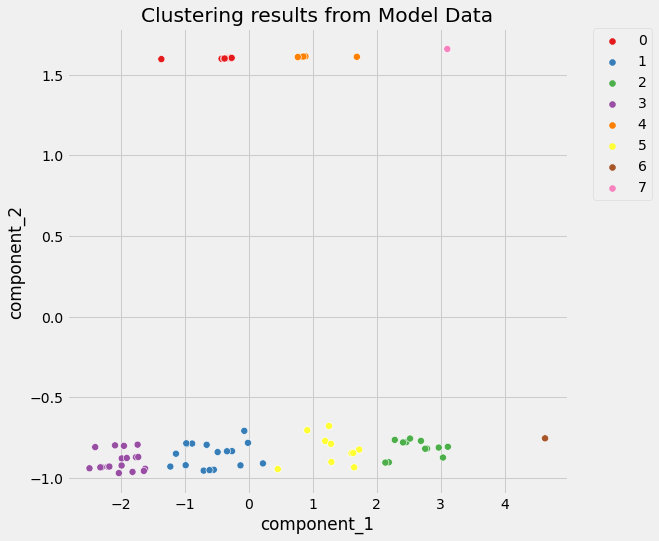

In [17]:
# Capture values from tuning
n_components, n_clusters, n_init, max_iter = final_parameters()

######### Build a pipeline to process the data #########
preprocessor = Pipeline([
    # use MinMaxScaler becuase we do not know if features follow a normal distribution
    ("scaler", StandardScaler()),
    
    # PCA class to perform dimensionality reduction
    ("pca", PCA(n_components=n_components, random_state=42)),
])


######### Build a pipeline to pipeline to perform clustering #########
clusterer = Pipeline([(
    "kmeans",
    KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        n_init=n_init,
        max_iter=max_iter,
        random_state=42
    )
)])


######### Chain the 2 pipelines to form the full pipeline #########
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clusterer", clusterer)
])

######### Use fit to perform all the pipeline steps on the data #########
pipe.fit(model_data)


######## Evaluate the performance by calculating the silhouette coefficient #########
preprocessed_data = pipe["preprocessor"].transform(model_data)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

######## Create a df with of model data #########

pca_df = pd.DataFrame(
    pipe["preprocessor"].transform(model_data),
    columns=["component_1", "component_2"],
)

######## Add a column with cluster assignments #########

pca_df["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

######## Create a plot of clusters #########

plt.style.use("fivethirtyeight")

plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    pca_df["component_1"],
    pca_df["component_2"],
    s=50,
    data=pca_df,
    hue= pca_df["predicted_cluster"],
#     style="true_label",
    palette="Set1",
)

scat.set_title("Clustering results from Model Data")

plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc=2,
    borderaxespad=0.0
)

plt.show()

In [19]:
######### Match BERT cluster lables to model data #########

# reindex to capture ticker symbols again
model_clusters =model_data.reindex()
# Add BERT clusters to df
model_clusters['Clusters'] = pca_df["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

######### Save user table as csv for flask matching #########
model_clusters.to_csv('static/resources/BERT_clusters.csv')